# Model Design

In this step we will analyse different candidates for bagging model ensemble. This will consider logistic regression estimators, tree estimators (random forest), and adaboost estimators.

Additonaly we will test if stratified undersampling is a better approach, or if we must just do simple undersampling.

All models will have soft predictions. This means that probabilities will be requested instead of hard predictions.
Additionally all candidates will be configured for no bootstrapping.

In synthesis we will evaluate six different candidates.

- **Candidate 1:** Bagging with Logistic Estimators on Stratified Undersampling Samples.
- **Candidate 2:** Bagging with Logistic Estimators on Regular Undersampling Samples.
- **Candidate 3:** Random Forest on Stratified Undersampling Samples.
- **Candidate 4:** Random Forest on Regular Undersampling Samples.
- **Candidate 5:** Bagging with AdaBoost Estimators on Stratified Undersampling Samples.
- **Candidate 6:** Bagging with AdaBoost Estimators on Regular Undersampling Samples.

This estimator candidates where selected to try different approaches and granting that estimators can return a probability prediction rather that a hard prediction. I'm aware there are additional options to consider, but for now seems a good starting point.


In [1]:
# Import Required Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from toolkit import Viz, Tools, PF

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score, roc_auc_score

from imblearn.ensemble import BalancedBaggingClassifier, BalancedRandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# Pre configure modules
warnings.filterwarnings('ignore')
sns.set()
random_state=42

In [2]:
# Function to reset data to original structures. With new features added. Tranform numeric features when needed.
def reset_data(num_transform=True):
    data, _, _, _ = PF.import_data()
    X, y = data[PF.cat_cols + PF.num_cols], data[PF.target_col]
    X = PF.add_features(X, y)
    X = PF.prepare_features(X, num_transform=True)

    strt = X[PF.strt_col]
    X.drop(PF.cntr_cols, axis=1, inplace=True)

    return data, X, y, strt

# Get data
data, X, y, strt = reset_data(num_transform=True)

---
## Model Prerequisites

### Train / Test Split

First we need to check if traditional train test split preserves strata proportions.

In [3]:
# Split data
X_train, X_test, strt_train, strt_test = train_test_split(X, strt, test_size=.2, random_state=random_state)
y_train, y_test = y[X_train.index], y[X_test.index]

In [4]:
# Check the proportion of target within train / test sets.
trgt_prop, trgt_cnt = pd.DataFrame(), y.value_counts()
trgt_prop['train cnt'] = y_train.value_counts()
trgt_prop['train pct'] = trgt_prop['train cnt'].div(trgt_cnt)
trgt_prop['test cnt'] = y_test.value_counts()
trgt_prop['test pct'] = trgt_prop['test cnt'].div(trgt_cnt)
trgt_prop

,train cnt,train pct,test cnt,test pct
0,99504,0.799955,24883,0.200045
1,90,0.849057,16,0.150943


In [5]:
# Check the proportion of strata within train / test sets.
strt_prop, strt_cnt = pd.DataFrame(), strt.value_counts()
strt_prop['train cnt'] = strt_train.value_counts()
strt_prop['train pct'] = strt_prop['train cnt'].div(strt_cnt)
strt_prop['test cnt'] = strt_test.value_counts()
strt_prop['test pct'] = strt_prop['test cnt'].div(strt_cnt)
strt_prop

,train cnt,train pct,test cnt,test pct
0,67547,0.799827,16905,0.200173
1,31957,0.800225,7978,0.199775
2,90,0.849057,16,0.150943


### Train / Test Split - Conclusions

- Data is split fairly even between train and test sets. Strata and target proportions follow split ratio as well.
- A 80/20 ratio will be used.

### Number of Estimators

Remember that we previously concluded that the number of estimators is critical to cover all available data, given the effect of stratified undersampling.

Remember that the strata proportions that will be used is: `strata_p = {0: 0.1, 1: 0.6, 2: 0.3}`.

In [6]:
# Get strata undersample proportions and counts
strata_p = PF.strata_p
n_vals = Tools.strat_undersample_counts(strt_train, strata_p, random_state)

In [7]:
# Compare for Strata 1
t_vals = strt.value_counts()
proxy_estimators = t_vals.loc[1] / n_vals[1]
proxy_estimators = int(round(proxy_estimators, 0))
proxy_estimators

277

### Number of Estimators - Conclusions

- When stratified undersampling, all values of Strata 2 will be kept in each subsample, Strata 0 and Strata 1 will be undersampled.
- Strata 0 provides few to no valuable information since are full zero instances on base zero dense columns.
- Strata 1 provide valuable information for ok target. This should be the main focus to estimate the number of predictors.
- Because of the high imbalance in target variable, bootstraping should be avoided to guarantee that most original data is used.
- The proxy estimator is the proportion between the number of Strata 1 elements in a subsample with all available ones.
- The proxy estimator is approx 280 estimators (if all subsample where different).

---
## Ensemble Candidates

In [8]:
# Create results variable where candidate results will be consolidated for further analysis
results = {}

### Bagging with Logistic Regression

In [9]:
# Get preprocessed data and split
data, X, y, strt = reset_data(num_transform=True)
X_train, X_test, strt_train, strt_test = train_test_split(X, strt, test_size=.2, random_state=random_state)
y_train, y_test = y[X_train.index], y[X_test.index]

#### Candidate 1: Stratifed Undersampling per Estimator

Ensemble Characteristics
- All estimators will have a subsample based on stratified undersampling strategy.
- The new target variable to use in training will be strata. **Multiclass (3 possible values) problem**.
- Probability will be requested for threshold analysis.
- Probability for Strata 0 and Strata 1 will be added into Target 0 (No Failure), Strata 2 will be Target 1 (Failure)


Logistic Regression Characteristics
- No hyperparamether limitations for now. We are evaluating best ensemble strategy for now.

In [10]:
# IMPORTANT: Set n_jobs according to available compute resources
n_jobs = 10

# Get Strata Proportions
strata_p = PF.strata_p
n_vals = Tools.strat_undersample_counts(strt_train, strata_p, random_state)

# Function to build Candidate 1
def candidate1(X_train, strt_train, strata_p, n_vals):
    logreg = LogisticRegression(class_weight=strata_p)

    bbagg = BalancedBaggingClassifier(base_estimator=logreg, sampling_strategy=n_vals,
                                      n_estimators=proxy_estimators, bootstrap=False, n_jobs=n_jobs,
                                      random_state=random_state)
    bbagg.fit(X_train, strt_train)
    return bbagg

# Build Candidate 1 and get probabilities prediction for training data
model1 = candidate1(X_train, strt_train, strata_p, n_vals)
strt_proba1 = model1.predict_proba(X_train)

# Transform strata probabilities to target probabilities
y_proba1 = list(map(lambda v: [v[0] + v[1], v[2]], strt_proba1))

# Consolidate results
results[1] = {'name':'StrtBaggLog', 'y_proba': y_proba1}

#### Candidate 2: Regular Undersampling per Estimator

Ensemble Characteristics

- All estimators will have a traditional undersampling strategy. 
- The proportion per sample will be 30% failure, 70% non failure.
- The problem will remain as binary.
- Probability will be requested for threshold analysis.


Logistic Regression Characteristics
- No hyperparamether limitations for now. We are evaluating best ensemble strategy for now.

In [11]:
# IMPORTANT: Set n_jobs according to available compute resources
n_jobs = 10

# Set Regular Undersample Target Rate
p = 0.3
r = p/(1-p)
target_p = {0:1-p, 1:p}

# Function to build Candidate 2
def candidate2(X_train, y_train, target_p, r):
    logreg = LogisticRegression(class_weight=target_p)

    bbagg = BalancedBaggingClassifier(base_estimator=logreg, sampling_strategy=r,
                                      n_estimators=proxy_estimators, bootstrap=False, n_jobs=n_jobs,
                                      random_state=random_state)

    bbagg.fit(X_train, y_train)
    return bbagg

# Build Candidate 2 and get probabilities prediction for training data
model2 = candidate2(X_train, y_train, target_p, r)
y_proba2 = model2.predict_proba(X_train)

# Consolidate results
results[2] = {'name':'UndBaggLog', 'y_proba': y_proba2}

### Random Forest

In [12]:
# Get preprocessed data (no numeric transformation needed) and split
data, X, y, strt = reset_data(num_transform=False)
X_train, X_test, strt_train, strt_test = train_test_split(X, strt, test_size=.2, random_state=random_state)
y_train, y_test = y[X_train.index], y[X_test.index]

#### Candidate 3: Stratifed Undersampling per Estimator
Ensemble Characteristics

- All estimators will have a subsample based on stratified undersampling strategy.
- The new target variable to use in training will be strata. Multiclass (3 possible values) problem.
- Probability will be requested for threshold analysis.
- Probability for Strata 0 and Strata 1 will be added into Target 0 (No Failure), Strata 2 will be Target 1 (Failure)


Decision Tree
- No hyperparamether limitations for now. We are evaluating best ensemble strategy for now.

In [13]:
# IMPORTANT: Set n_jobs according to available compute resources
n_jobs = 10

# Get Strata Proportions
strata_p = PF.strata_p
n_vals = Tools.strat_undersample_counts(strt_train, strata_p, random_state)

# Function to build Candidate 3
def candidate3(X_train, strt_train, strata_p, n_vals):
    brf = BalancedRandomForestClassifier(class_weight=strata_p, sampling_strategy=n_vals,
                                        n_estimators=proxy_estimators, bootstrap=False, n_jobs=n_jobs,
                                        random_state=random_state)

    brf.fit(X_train, strt_train)
    return brf

# Build Candidate 3 and get probabilities prediction for training data
model3 = candidate3(X_train, strt_train, strata_p, n_vals)
strt_proba3 = model3.predict_proba(X_train)

# Transform strata probabilities to target probabilities
y_proba3 = list(map(lambda v: [v[0] + v[1], v[2]], strt_proba3))

# Consolidate results
results[3] = {'name':'StrtRandFor', 'y_proba': y_proba3}

#### Candidate 4: Undersampling per Estimator
Ensemble Characteristics

- All estimators will have a traditional undersampling strategy. 
- The proportion per sample will be 30% failure, 70% non failure.
- The problem will remain as binary.
- Probability will be requested for threshold analysis.


Decision Tree
- No hyperparamether limitations for now. We are evaluating best ensemble strategy for now.

In [14]:
# IMPORTANT: Set n_jobs according to available compute resources
n_jobs = 10

# Set Regular Undersample Target Rate
p = 0.3
r = p/(1-p)
target_p = {0:1-p, 1:p}

# Function to build Candidate 4
def candidate4(X_train, y_train, target_p, r):
    brf = BalancedRandomForestClassifier(class_weight=target_p, sampling_strategy=r,
                                        n_estimators=proxy_estimators, bootstrap=False, n_jobs=n_jobs,
                                        random_state=random_state)
                                    
    brf.fit(X_train, y_train)
    return brf

# Build Candidate 4 and get probabilities prediction for training data
model4 = candidate4(X_train, y_train, target_p, r)
y_proba4 = model4.predict_proba(X_train)

# Consolidate results
results[4] = {'name':'UndRandFor', 'y_proba': y_proba4}

### Bagging + Boosting

In [15]:
# Get preprocessed data (no numeric transformation needed) and split
data, X, y, strt = reset_data(num_transform=False)
X_train, X_test, strt_train, strt_test = train_test_split(X, strt, test_size=.2, random_state=random_state)
y_train, y_test = y[X_train.index], y[X_test.index]

#### Candidate 5: Stratifed Undersampling per Estimator
Ensemble Characteristics
- All estimators will have a subsample based on stratified undersampling strategy.
- The new target variable to use in training will be strata. Multiclass (3 possible values) problem.
- Probability will be requested for threshold analysis.
- Probability for Strata 0 and Strata 1 will be added into Target 0 (No Failure), Strata 2 will be Target 1 (Failure)


AdaBoost
- Decision Trees among Adaboost wont be limited to 1 level (stump)
- Number of estimates within each Adaboost will be limited to 10 to avoy long training times.
- No additional hyperparamether limitations for now. We are evaluating best ensemble strategy for now.

In [16]:
# IMPORTANT: Set n_jobs according to available compute resources
n_jobs = 10

# Get Strata Proportions
strata_p = PF.strata_p
n_vals = Tools.strat_undersample_counts(strt_train, strata_p, random_state)

# Function to build Candidate 5
def candidate5(X_train, strt_train, strata_p, n_vals):
    tree = DecisionTreeClassifier(class_weight=strata_p)
    
    boost = AdaBoostClassifier(base_estimator=tree, n_estimators=10)

    bbagg = BalancedBaggingClassifier(base_estimator=boost, sampling_strategy=n_vals,
                                      n_estimators=proxy_estimators, bootstrap=False, n_jobs=n_jobs,
                                      random_state=random_state)
    bbagg.fit(X_train, strt_train)
    return bbagg

# Build Candidate 5 and get probabilities prediction for training data
model5 = candidate5(X_train, strt_train, strata_p, n_vals)
strt_proba5 = model5.predict_proba(X_train)

# Transform strata probabilities to target probabilities
y_proba5 = list(map(lambda v: [v[0] + v[1], v[2]], strt_proba5))

# Consolidate results
results[5] = {'name':'StrtBaggBst', 'y_proba': y_proba5}

#### Candidate 6: Undersampling per Estimator
Ensemble Characteristics

- All estimators will have a traditional undersampling strategy. 
- The proportion per sample will be 30% failure, 70% non failure.
- The problem will remain as binary.
- Probability will be requested for threshold analysis.


AdaBoost
- Decision Trees among Adaboost wont be limited to 1 level (stump)
- Number of estimates within each Adaboost will be limited to 10 to avoy long training times.
- No additional hyperparamether limitations for now. We are evaluating best ensemble strategy for now.

In [17]:
# IMPORTANT: Set n_jobs according to available compute resources
n_jobs = 10

# Set Regular Undersample Target Rate
p = 0.3
r = p/(1-p)
target_p = {0:1-p, 1:p}

# Function to build Candidate 6
def candidate6(X_train, y_train, target_p, r):
    tree = DecisionTreeClassifier(class_weight=target_p)
    
    boost = AdaBoostClassifier(base_estimator=tree, n_estimators=10)

    bbagg = BalancedBaggingClassifier(base_estimator=boost, sampling_strategy=r,
                                      n_estimators=proxy_estimators, bootstrap=False, n_jobs=n_jobs,
                                      random_state=random_state)
    bbagg.fit(X_train, y_train)
    
    return bbagg

# Build Candidate 6 and get probabilities prediction for training data
model6 = candidate6(X_train, y_train, target_p, r)
y_proba6 = model6.predict_proba(X_train)

# Consolidate results
results[6] = {'name':'UndBaggBst', 'y_proba': y_proba6}

---
## Result Analysis

To calculate fairly all candidates, we will use a **0.95** threshold. As referenced previously, we will focus on F1, Precision, Recall and AUC scores. All this scores can help us highlight False Negative and False Positive effect on predictions.  

Additionally we will get the confusion matrix per candidate on the specified threshold to get a detailed view of results obtained by each one of them.

In [19]:
# Define Threshold to compare model candidates.
threshold = 0.95

# Function to calculate Scores and Confusion Matrixes
def get_scores(threshold, results):
    conf_matrixes, scores = {}, []
    for k, r in results.items(): 
        y_proba = r['y_proba']
        y_pred = list(map(lambda v: 1 if v[1] >= threshold else 0, y_proba))
        y_proba = [v[1] for v in y_proba]
        
        f1 = f1_score(y_train, y_pred)
        recall = recall_score(y_train, y_pred)
        precision = precision_score(y_train, y_pred)
        auroc = roc_auc_score(y_train, y_proba)

        conf_matrix = confusion_matrix(y_train, y_pred)
        conf_matrix = pd.DataFrame(conf_matrix, index=y_train.unique(), columns=y_train.unique())

        scores.append({'id':k, 'name': r['name'], 'F1-score': f1, 'Recall': recall, 'Precision': precision, 'AUROC':auroc})
        conf_matrixes[k] = conf_matrix

    scores = pd.DataFrame(scores).set_index('id')

    return scores, conf_matrixes

# Calculate Scores and Confusion Matrixes
scores, conf_matrixes = get_scores(threshold, results)

### Visualize Candidate Scores

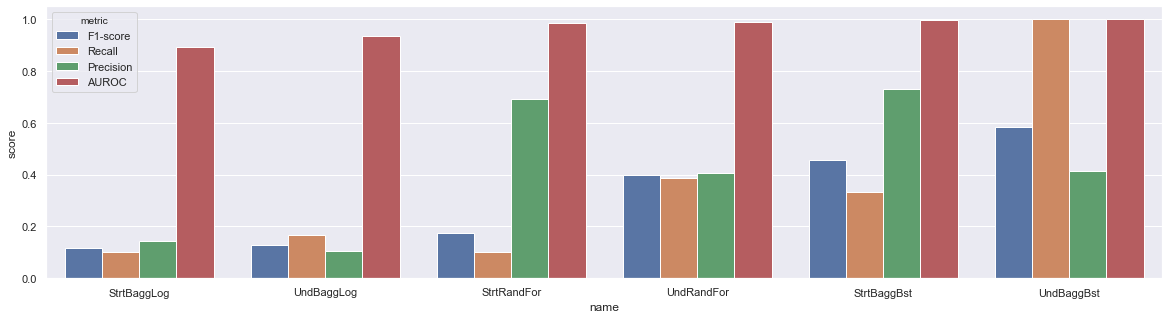

In [20]:
# Visualize Scores per Candidate
m_scores = scores.melt(id_vars=['name'], var_name='metric', value_name='score')
sns.barplot(data=m_scores, x='name', y='score', hue='metric', ax=Viz.get_figure(1))
plt.show()

### Visualize Confusion Matrixes

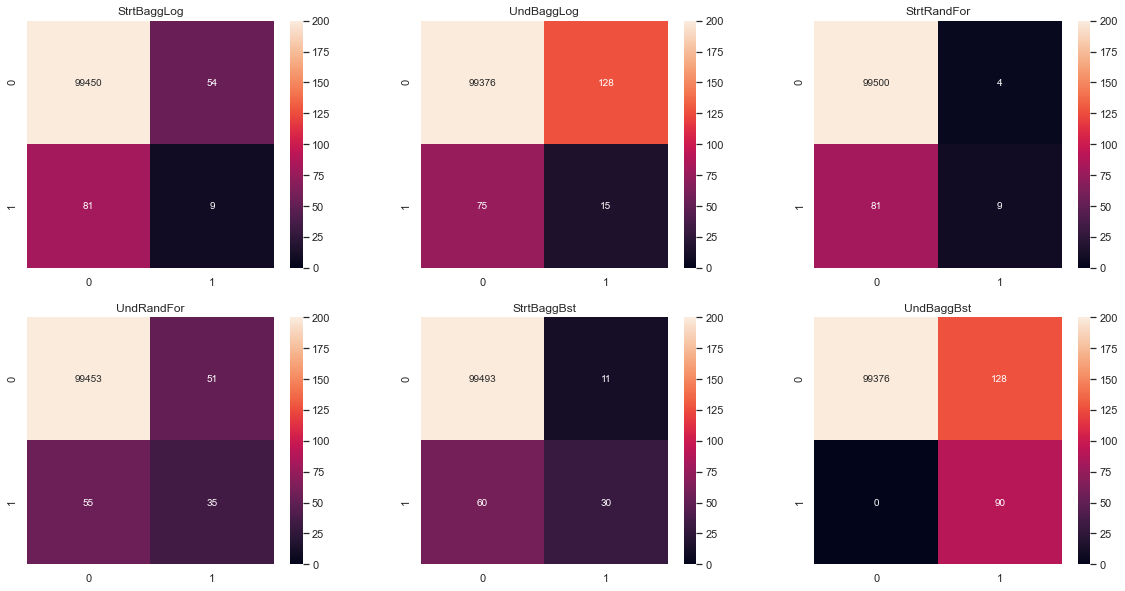

In [21]:
# Visualize Confusion Matrixes
Viz.change_default(per_row=3)
ax = Viz.get_figure(6)

for i, conf_matrix in conf_matrixes.items():
    sns.heatmap(conf_matrix, vmin= 0, vmax=200, square=True, annot=True, fmt='d', ax=ax[i-1])
    ax[i-1].set_title(results[i]['name'])

plt.show()

### Result Analysis - Conclusions
- Threshold used is 95% of probability of failure. This will narrow predictions giving a best score for each ensemble.
- No hyperparamether was tuned to evaluate ensemble strategy only.
- Accuracy won´t be used as decision score. F1 Score will be used instead to get the best False Positive and False Negative ratio.
- **Stratified Undersampling shows better results than Regular Undersampling**. This is true for all bagging strategies (no matter estimators' algorithm.)
- Logistic Regression based models don't show good results in this run.
- **Stratified Random Forest and Bagg + Boost models show best behaviour**. They ilustrate the **Recall / Precision tradeoff**.
- Stratified Random Forest favors precision.
- Stratifies Bagg + Boost favors recall.
- Both models will be tuned, but from this point is important to better understand the impact of False Pasitives and False Negatives to better select a final model. This information is not yet available.